In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import sacpy as scp
import cartopy.feature as cfeat
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.ticker import MultipleLocator
import cmaps
import sacpy.Map
try :
    cmap1 = cmaps.cmp_b2r
    cmap2 = cmaps.ncl_default
except:
    pass

In [2]:
heating = xr.open_dataarray("PMM_allheat.nc")
time1 = "1980-01"
time2 = "2018-12"
sst_loc = "../../DATA/HadISST_sst_2x2.nc"
sst = xr.open_dataset(sst_loc)['sst'].loc[time1:time2,-60:60]
ssta = scp.get_anom(sst)
ssta_eof = ssta.loc[:, -20:30, 150:275]
eof = scp.EOF(np.array(ssta_eof))
eof.solve()
pc = eof.get_pc(npt=3)
pt = eof.get_pt(npt=3)
sst_pt = ssta.loc[:,-30:30,120:280]
ssta_lr = scp.LinReg(pc[1],sst_pt)
ctrl_dat = xr.open_dataset("./DF001CTRL_007101.01.mon.nc")
exp_dat = xr.open_dataset("./PMM_heat_res.nc")

time = pd.date_range("1971-01-01","2001-07-30",freq="MS")
ctrl_dat['time'] = time
exp_dat['time'] = time[:360]

/Users/zilumeng/miniconda3/envs/sacpy/lib/python3.8/site-packages/xarray/coding/times.py:150: SerializationWarning: Ambiguous reference date string: 71-01-01 06:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0071-01-01 06:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/Users/zilumeng/miniconda3/envs/sacpy/lib/python3.8/site-packages/xarray/coding/times.py:699: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/zilumeng/miniconda3/envs/sacpy/lib/python3.8/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cfti

In [3]:
def get_loc_data(season, names,lon=slice(120,280),lat=slice(60,-30)):
    if season == "MAM": months = [11,12,1]
    elif season == "SON": months = [7,8,9]
    elif season == "DJF": months = [10,11,12]
    elif season == "JJA": months = [4,5,6]
    elif season == "all": 
        months = None
    ctl_re_ls = []
    exp_re_ls = []
    for name in names:
        if name == "slp":
            ctl_re = ctrl_dat[name].loc["1976":, lat, lon]
            exp_re = exp_dat[name].loc["1976":, lat, lon]
        elif name == "u10" or name == "v10":
            ctl_re = ctrl_dat[name].loc["1976":, 10, lat, lon]
            exp_re = exp_dat[name].loc["1976":, 10, lat, lon]
        elif name == "geopoth":
            ctl_re = ctrl_dat[name].loc["1976":, 50000., lat, lon]
            exp_re = exp_dat[name].loc["1976":, 50000., lat, lon]
        else:
            ctl_re = ctrl_dat[name].loc["1976":, lat, lon]
            exp_re = exp_dat[name].loc["1976":, lat, lon]
        if season != "all":
            ctl_re = scp.XrTools.spec_moth_yrmean(ctl_re, months)

            exp_re = scp.XrTools.spec_moth_yrmean(exp_re, months)
        else:
            ctl_re = ctl_re
            exp_re = exp_re
        ctl_re_ls.append(ctl_re)
        exp_re_ls.append(exp_re)
    return ctl_re_ls, exp_re_ls
res_ls = get_loc_data("all", ["u10", "v10",'slp','ahfl','precip'])
import pickle

with open('Heating_res.pickle', 'wb') as handle:
    pickle.dump(res_ls, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [4]:
def get_loc_data(season, names,lon=slice(120,280),lat=slice(70,-30)):
    if season == "MAM": months = [11,12,1]
    elif season == "SON": months = [7,8,9]
    elif season == "DJF": months = [10,11,12]
    elif season == "JJA": months = [4,5,6]
    elif season == "all": 
        months = None
    ctl_re_ls = []
    exp_re_ls = []
    for name in names:
        if name == "slp":
            ctl_re = ctrl_dat[name].loc["1976":, lat, lon]
            exp_re = exp_dat[name].loc["1976":, lat, lon]
        elif name == "u10" or name == "v10":
            ctl_re = ctrl_dat[name].loc["1976":, 10, lat, lon]
            exp_re = exp_dat[name].loc["1976":, 10, lat, lon]
        elif name == "geopoth":
            ctl_re = ctrl_dat[name].loc["1976":, 50000., lat, lon]
            exp_re = exp_dat[name].loc["1976":, 50000., lat, lon]
        else:
            ctl_re = ctrl_dat[name].loc["1976":, lat, lon]
            exp_re = exp_dat[name].loc["1976":, lat, lon]
        if season != "all":
            ctl_re = scp.XrTools.spec_moth_yrmean(ctl_re, months)

            exp_re = scp.XrTools.spec_moth_yrmean(exp_re, months)
        else:
            ctl_re = ctl_re
            exp_re = exp_re
        ctl_re_ls.append(ctl_re)
        exp_re_ls.append(exp_re)
    return ctl_re_ls, exp_re_ls

wind_dc = {}
wind_dc1 = {}
lhf_dc = {}
slp_dc = {}
for season in ["MAM","SON","DJF"]:
    (u0, v0,lhf0,slp0), (u1, v1,lhf1,slp1) = get_loc_data(season, ["u10", "v10","ahfl","slp"])
    ud ,pvu = scp.two_mean_test(np.array(u1), np.array(u0))
    vd ,pvv = scp.two_mean_test(np.array(v1), np.array(v0))
    slpd,pslp = scp.two_mean_test(np.array(slp1), np.array(slp0))
    wind_dc[season] = [[ud/5.4 ,pvu],[vd/5.4 ,pvv]]
    lhf_diff,plhf = scp.two_mean_test(np.array(lhf1), np.array(lhf0))
    ud[(pvu>0.05) & (pvv>0.05)] = np.NAN
    vd[(pvu>0.05) & (pvv>0.05)] = np.NAN
    wind_dc1[season] = [[ud/5.4 ,pvu],[vd/5.4 ,pvv]]
    lhf_dc[season] = [lhf_diff/5.4,plhf]
    slp_dc[season] = [slpd/100/4,pslp]

In [9]:
(u0, v0,lhf0), (u1, v1,lhf1) = get_loc_data("SON", ["u10", "v10","ahfl"])
u00 = u1 - u0
v00 = v1 - v0
lhf00 = lhf1 - lhf0
(u0, v0,lhf0), (u1, v1,lhf1) = get_loc_data("MAM",["u10", "v10","ahfl"])
u01 = u1 - u0
v01 = v1 - v0
lhf01 = lhf1 - lhf0
ud1 ,pvu1 = scp.two_mean_test(np.array(u01), np.array(u00))
vd1 ,pvv1 = scp.two_mean_test(np.array(v01), np.array(v00))
lhfd1,plhf1 = scp.two_mean_test(np.array(lhf01), np.array(lhf00))
ud1 /= 5.4
vd1 /= 5.4
ud1[(pvu1>0.05) & (pvv1>0.05)] = np.NAN
vd1[(pvu1>0.05) & (pvv1>0.05)] = np.NAN

In [10]:
np.nanmax(ud1)

0.57759106

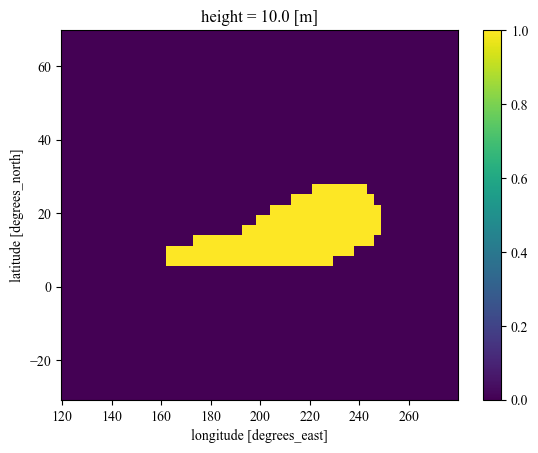

In [11]:
pmm_region_xr = -ssta_lr.slope.interp(lon = u0.lon,lat = u0.lat)
pmm_region_xr  = pmm_region_xr  > 0.17
pmm_region_xr [pmm_region_xr.lat<=5] = False 
# pmm_region_xr[pmm_region_xr.lat==29] = False
# ssta_lr.slope.splot()
# pmm_region_xr.plot()
pmm_region_xr1 = -ssta_lr.slope
pmm_region_xr1  = pmm_region_xr  > 0.17
pmm_region_xr1 [pmm_region_xr1.lat<=5] = False 
# pmm_region_xr[pmm_region_xr.lat==29] = False
# ssta_lr.slope.splot()
pmm_region_xr1.plot()

[-0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4]
4.1991243
2.507338


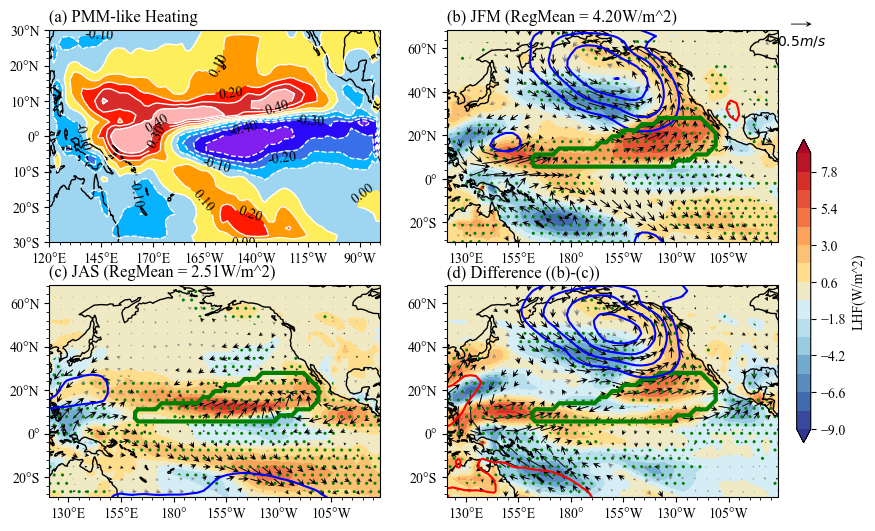

In [16]:
from matplotlib import colors

heating1 = heating.loc[dict(lon=slice(120, 280), lat=slice(-30, 30))] * 0.26
cmap = colors.ListedColormap(['blue', "none", 'red'])
# cmap1 = cmaps.cmp_b2r
bounds = [-1e10, -1e-5, 1e-5, 1e10]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=[12 / 1.5 + 1.4, 7 / 1.5 + 1.4])
abcd = ['a', 'b', 'c', 'd']
idx = 1
ax = fig.add_subplot(2, 2, idx, projection=ccrs.PlateCarree(central_longitude=180))
idx += 1
m = ax.scontourf(heating1.lon, heating1.lat, heating1, cmap=cmap2, levels=np.linspace(-0.4, 0.4, 9))
n = ax.scontour(m, colors="white", linewidths=1)
ax.clabel(n, fmt="%.2f", colors="black")
ax.init_map()
ax.set_title("(a) PMM-like Heating", loc="left")
# plt.colorbar(m)
print(m.levels)
for i in range(2):
    season = ["MAM", "SON"][i]
    title_se = ["JFM", "JAS"][i]
    ax = fig.add_subplot(2, 2, idx, projection=ccrs.PlateCarree(central_longitude=180))
    idx += 1
    m1 = ax.scontourf(u0.lon, u0.lat, lhf_dc[season][0], cmap=cmap1, levels=np.linspace(-9, 9, 16))
    ax.sig_plot(u0.lon, u0.lat, lhf_dc[season][1], color="green")
    q1 = ax.squiver(u0.lon,
                    u0.lat,
                    wind_dc[season][0][0],
                    wind_dc[season][1][0],
                    stepx=2,
                    stepy=2,
                    scale=8,
                    color="gray",
                    headwidth=7,
                    headlength=7)
    q = ax.squiver(u0.lon,
                   u0.lat,
                   wind_dc1[season][0][0],
                   wind_dc1[season][1][0],
                   stepx=2,
                   stepy=2,
                   scale=8,
                   color="black",
                   headwidth=7,
                   headlength=7)
    ax.scontour(u0.lon, u0.lat, slp_dc[season][0], norm=norm, cmap=cmap, levels=np.arange(-5.6, 4, 0.4))
    regmean = lhf_dc[season][0][pmm_region_xr].mean()
    ax.scontour(pmm_region_xr1.lon, pmm_region_xr1.lat, pmm_region_xr1, levels=[0.5], colors="green", linewidths=3)
    # ax.streamplot(u0.lon,u0.lat,wind_dc[season][0][0],wind_dc[season][1][0],transform=ccrs.PlateCarree())
    ax.init_map(stepy=20)
    ax.set_title("({}) {} (RegMean = {:.2f}W/m^2)".format(abcd[i + 1], title_se, regmean), loc="left")
    print(regmean)
ax_cb = fig.add_axes([0.92, 0.2, 0.015, 0.5])
cb = fig.colorbar(m1, cax=ax_cb, orientation="vertical", spacing="proportional")
cb.set_label("LHF(W/m^2)")
ax.quiverkey(q, 0.925, 0.89, 0.5, r'$0.5 {m}/{s}$', labelpos='S', coordinates='figure')
ax = fig.add_subplot(2, 2, idx, projection=ccrs.PlateCarree(central_longitude=180))
m1 = ax.scontourf(u0.lon, u0.lat, lhf_dc["MAM"][0] - lhf_dc["SON"][0], cmap=cmap1, levels=np.linspace(-9, 9, 16))
ax.scontour(pmm_region_xr1.lon, pmm_region_xr1.lat, pmm_region_xr1, levels=[0.5], colors="green", linewidths=3)
ud2 = wind_dc["MAM"][0][0] - wind_dc["SON"][0][0]
vd2 = wind_dc["MAM"][1][0] - wind_dc["SON"][1][0]
# ud2 = np.copy(ud1)[wind_dc1["MAM"][0][0]-wind_dc1["SON"][0][0]]

q = ax.squiver(u0.lon, u0.lat, ud2, vd2, stepx=2, stepy=2, scale=8, color="gray", headwidth=7, headlength=7)
q = ax.squiver(u0.lon, u0.lat, ud1, vd1, stepx=2, stepy=2, scale=8, color="black", headwidth=7, headlength=7)
ax.scontour(u0.lon, u0.lat, slp_dc["MAM"][0] - slp_dc["SON"][0], norm=norm, cmap=cmap, levels=np.arange(-5.6, 4, 0.4))
ax.sig_plot(u0.lon, u0.lat, plhf1, color="green")

# ax.quiverkey(q, 0.8, 0.94, 0.5, r'$0.5 {m}/{s}$', labelpos='S',
#   coordinates='figure')
ax.set_title("(d) Difference ((b)-(c))", loc="left")
ax.init_map(stepy=20)
plt.savefig("./pic/Fig5.png", dpi=300)
# print(m1.levels)
